# Binned fits solutions: Exercise 12.1

Write a program that fits the events saved in the file
   [```dati.txt```](https://raw.githubusercontent.com/UnimibFisicaLaboratori/UnimibFisicaLabStatPython/main/book/lectures/Lecture_12/exercises/dati.txt?token=GHSAT0AAAAAACD74PL6IWYFVSGIAUFHKYISZGPJ7AA).
  * Take care to determine the range and binning of the histogram used for the fit
    based on the events themselves,
    writing appropriate algorithms to determine the minimum and maximum of the sample
    and a reasonable estimate of the number of bins to use.
  * Determine the initial values of the fit parameters
    using the techniques described in the lesson.
  * Print the fit result on the screen.
  * Plot the histogram with the fitted model overlaid.
  * Which parameters are correlated, and which are anti-correlated with each other?

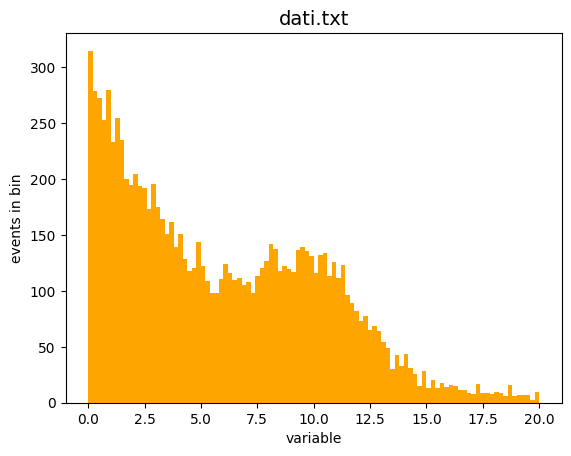

In [1]:
import numpy as np
from math import floor, ceil
from matplotlib import pyplot as plt

# read the file
with open('dati.txt') as f:
    sample = [float (x) for x in f.readlines()]

# show its content in a histogram
sample_mean = np.mean (sample)
sample_sigma = np.std (sample)
# first guess of x_axis range, before looking at the histogram
# x_min = sample_mean - 3 * sample_sigma 
# x_max = sample_mean + 3 * sample_sigma
x_min   = floor (min (sample))
x_max   = ceil (max (sample))
x_range = (x_min, x_max)
N_bins  = floor (len (sample)/100)

# build a numpy histogram containing the data counts in each bin
bin_content, bin_edges = np.histogram (sample, bins = N_bins, range = x_range)

fig, ax = plt.subplots ()
ax.set_title ('dati.txt', size=14)
ax.set_xlabel('variable')
ax.set_ylabel('events in bin')
ax.hist (sample,
         bins = bin_edges,
         color = 'orange',
        )
plt.show ()

### building the fitting model

In [2]:
from iminuit import Minuit
from scipy.stats import expon, norm
from iminuit.cost import ExtendedBinnedNLL

# the fitting function
def mod_total (bin_edges, N_signal, mu, sigma, N_background, tau):
    return N_signal * norm.cdf (bin_edges, mu, sigma) + \
            N_background * expon.cdf (bin_edges, 0, tau)

N_events = sum (bin_content)

# the cost function for the fit
my_cost_func = ExtendedBinnedNLL (bin_content, bin_edges, mod_total)

# the fitting algoritm
my_minuit = Minuit (my_cost_func, 
                    N_signal = N_events, mu = sample_mean, sigma = sample_sigma, # signal input parameters
                    N_background = N_events, tau = 1.)                          # background input parameters

# bounds the following parameters to being positive
my_minuit.limits['N_signal', 'N_background', 'sigma', 'tau'] = (0, None)

### fitting with only the background model
to determine the background parameters to be used as starting point for the final fit

In [3]:
# fixing the following parameters,
# setting the signal to zero for a first background-only preliminary fit
my_minuit.values["N_signal"] = 0
my_minuit.fixed["N_signal", "mu", "sigma"] = True

# we temporarily mask out the signal
bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
my_cost_func.mask = (bin_centres < 5) | (15 < bin_centres)

my_minuit.migrad ()
my_minuit.minos ()
print (my_minuit.valid)
display (my_minuit)

True


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 43.56 (χ²/ndof = 0.9)      │              Nfcn = 142              │
│ EDM = 9.51e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │     0     │   0.1e3   │            │            │    0    │         │  yes  │
│ 1 │ mu           │   5.92    │   0.06    │            │            │         │         │  yes  │
│ 2 │ sigma        │   4.43    │   0.04    │            │            │    0    │         │  yes  │
│ 3 │ N_background │  7.98e3   │  0.13e3   │  -0.13e3   │   0.13e3   │    0    │         │       │
│ 4 │ tau          │    5.2    │    0.1    │    -0.1    │    0.1     │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │     N_background      │          tau          │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.13e3  │  0.13e3   │   -0.1    │    0.1    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │            0            0            0            0        0.000 │
│           mu │            0            0            0            0        0.000 │
│        sigma │            0            0            0            0        0.000 │
│ N_background │            0            0            0     1.71e+04        7.192 │
│          tau │        0.000        0.000        0.000        7.192       0.0106 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

### fitting with only the signal model
to estimate the signal parameters to be used as starting point for the final fit

In [4]:
my_cost_func.mask = None # remove mask
my_minuit.fixed = False # release all parameters
my_minuit.fixed["N_background", "tau"] = True # fix background amplitude
my_minuit.values["N_signal"] = N_events - my_minuit.values["N_background"] # do not start at the limit

my_minuit.migrad ()
my_minuit.minos ()
print (my_minuit.valid)
display (my_minuit)

True


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 88.68 (χ²/ndof = 0.9)      │              Nfcn = 406              │
│ EDM = 8.41e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │  2.23e3   │  0.07e3   │  -0.07e3   │   0.07e3   │    0    │         │       │
│ 1 │ mu           │   9.99    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 2 │ sigma        │   2.04    │   0.06    │   -0.06    │    0.07    │    0    │         │       │
│ 3 │ N_background │  7.98e3   │  0.13e3   │  -0.13e3   │   0.13e3   │    0    │         │  yes  │
│ 4 │ tau          │    5.2    │    0.1    │    -0.1    │    0.1     │    0    │         │  yes  │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │     N_background      │          tau          │       N_signal        │          mu           │         sigma         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.13e3  │  0.13e3   │   -0.1    │    0.1    │    -70    │    70     │   -0.08   │   0.08    │   -0.06   │   0.07    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │      4.9e+03       -1.390        1.744          0e3          0e3 │
│           mu │       -1.390      0.00572       -0.001        0.000        0.000 │
│        sigma │        1.744       -0.001      0.00421        0.000        0.000 │
│ N_background │          0e3        0.000        0.000            0            0 │
│          tau │          0e3        0.000        0.000            0            0 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

### final fit over the full range, with the full model

In [5]:
my_minuit.fixed = False # release all parameters
my_minuit.migrad ()
my_minuit.minos ()
print (my_minuit.valid)
display (my_minuit)

True


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 87.78 (χ²/ndof = 0.9)      │              Nfcn = 898              │
│ EDM = 5.83e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │  2.31e3   │  0.11e3   │  -0.11e3   │   0.11e3   │    0    │         │       │
│ 1 │ mu           │   9.97    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 2 │ sigma        │   2.09    │   0.08    │   -0.08    │    0.08    │    0    │         │       │
│ 3 │ N_background │  7.85e3   │  0.14e3   │  -0.14e3   │   0.14e3   │    0    │         │       │
│ 4 │ tau          │   5.11    │   0.11    │   -0.11    │    0.11    │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │     N_background      │          tau          │       N_signal        │          mu           │         sigma         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.14e3  │  0.14e3   │   -0.11   │   0.11    │  -0.11e3  │  0.11e3   │   -0.08   │   0.08    │   -0.08   │   0.08    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │     1.18e+04       -2.857        5.921     -0.011e6       -8.275 │
│           mu │       -2.857      0.00621       -0.002        3.034        0.001 │
│        sigma │        5.921       -0.002      0.00681       -6.641       -0.005 │
│ N_background │     -0.011e6        3.034       -6.641     2.01e+04       10.022 │
│          tau │       -8.275        0.001       -0.005       10.022       0.0129 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

### The parameter values and uncertainties

In [6]:
print (my_minuit.params)

┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │  2.31e3   │  0.11e3   │  -0.11e3   │   0.11e3   │    0    │         │       │
│ 1 │ mu           │   9.97    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 2 │ sigma        │   2.09    │   0.08    │   -0.08    │    0.08    │    0    │         │       │
│ 3 │ N_background │  7.85e3   │  0.14e3   │  -0.14e3   │   0.14e3   │    0    │         │       │
│ 4 │ tau          │   5.11    │   0.11    │   -0.11    │    0.11    │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [7]:
#print (my_minuit.merrors)
for elem in my_minuit.merrors:
    print (elem + ' : + ' + str (my_minuit.merrors[elem].upper) + ' ' + str (my_minuit.merrors[elem].lower))

N_background : + 141.66775442102366 -142.364219981618
tau : + 0.11391045360413823 -0.1132506900991527
N_signal : + 110.4271242229494 -106.93841130331256
mu : + 0.07828724029088165 -0.07937371073356515
sigma : + 0.08437594658376164 -0.08092110138081635


In [8]:
for key in my_minuit.parameters : # parameters is a tuple containing the parameter names
    print ('parameter ' + key + ': ' + 
           str (my_minuit.values[key]) + ' +- ' + 
           str (my_minuit.errors[key]) + '   |   ' +
           str (my_minuit.merrors[key].upper) + ' ' + 
           str (my_minuit.merrors[key].lower)
          )

parameter N_signal: 2308.1512554581673 +- 108.58035217734141   |   110.4271242229494 -106.93841130331256
parameter mu: 9.97394336750722 +- 0.07878644064750405   |   0.07828724029088165 -0.07937371073356515
parameter sigma: 2.0865308514039067 +- 0.08254069031557365   |   0.08437594658376164 -0.08092110138081635
parameter N_background: 7848.772941008475 +- 141.92667441673666   |   141.66775442102366 -142.364219981618
parameter tau: 5.112032036497856 +- 0.11349561166179578   |   0.11391045360413823 -0.1132506900991527


### Covariance matrix of the parameters

In [9]:
print (my_minuit.covariance)

┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │     1.18e+04       -2.857        5.921     -0.011e6       -8.275 │
│           mu │       -2.857      0.00621       -0.002        3.034        0.001 │
│        sigma │        5.921       -0.002      0.00681       -6.641       -0.005 │
│ N_background │     -0.011e6        3.034       -6.641     2.01e+04       10.022 │
│          tau │       -8.275        0.001       -0.005       10.022       0.0129 │
└──────────────┴──────────────────────────────────────────────────────────────────┘


In [10]:
print (my_minuit.covariance[0][1])
print (my_minuit.covariance['N_signal']['N_background'])

-2.8568870609223675
-10688.478687308894


In [11]:
# get the correlation matrix:
print (my_minuit.covariance.correlation ())

┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │            1         -0.3          0.7         -0.7         -0.7 │
│           mu │         -0.3            1         -0.4          0.3          0.1 │
│        sigma │          0.7         -0.4            1         -0.6         -0.5 │
│ N_background │         -0.7          0.3         -0.6            1          0.6 │
│          tau │         -0.7          0.1         -0.5          0.6            1 │
└──────────────┴──────────────────────────────────────────────────────────────────┘


# Binned fits solutions: Exercise 12.2 

Generate a file ```dati_2.txt``` containing 10,000 events
distributed according to a Gaussian probability distribution.
  * Write a program that fits the events saved in the file ```dati_2.txt```
    using the binned and unbinned maximum likelihood methods,
    and compare the results of the two techniques.

### sample generation and file saving

In [1]:
from myrand import generate_TCL_ms

N_evt = 10_000
sample_gaus = generate_TCL_ms (1., 0.7, N_evt)
print (len (sample_gaus))

with open (r'dati_2.txt', 'w') as fp :
    for item in sample_gaus:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

10000
Done


### fit with binned maximum likelihood

In [2]:
import numpy as np
from iminuit import Minuit
from math import floor, ceil
from iminuit.cost import ExtendedBinnedNLL
from matplotlib import pyplot as plt
from scipy.stats import expon, norm


bin_content, bin_edges = np.histogram (sample_gaus, bins = floor (N_evt/100), 
                                       range = (floor (min (sample_gaus)), ceil (max (sample_gaus))))

def mod_signal_bin (bin_edges, N_signal, mu, sigma):
    return N_signal * norm.cdf (bin_edges, mu, sigma)

my_cost_func_bin = ExtendedBinnedNLL (bin_content, bin_edges, mod_signal_bin)
my_minuit_bin = Minuit (
                        my_cost_func_bin, 
                        N_signal = sum (bin_content), 
                        mu = np.mean (sample_gaus), 
                        sigma = np.std (sample_gaus),
                       )
my_minuit_bin.limits['N_signal', 'sigma'] = (0, None)
my_minuit_bin.migrad ()
assert my_minuit_bin.valid
display (my_minuit_bin)

# get the estimate of the N_background and tau parameter for the final fit
mean_bin = [my_minuit_bin.values[1], my_minuit_bin.errors[1]]
sigma_bin = [my_minuit_bin.values[2], my_minuit_bin.errors[2]]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 102.8 (χ²/ndof = 1.1)      │              Nfcn = 32               │
│ EDM = 1.4e-05 (Goal: 0.0002)     │            time = 1.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal │  10.0e3   │   0.1e3   │            │            │    0    │         │       │
│ 1 │ mu       │   -2.77   │   0.05    │            │            │         │         │       │
│ 2 │ sigma    │   4.849   │   0.035   │            │            │    0    │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬────────────────────────────┐
│          │ N_signal       mu    sigma │
├──────────┼────────────────────────────┤
│ N_signal │    1e+04   0.0015   0.0153 │
│       mu │   0.0015  0.00237   0.0000 │
│    sigma │   0.0153   0.0000  0.00123 │
└──────────┴────────────────────────────┘

### fit with unbinned maximum likelihood

In [3]:
from iminuit.cost import UnbinnedNLL

def mod_signal_unb (x, mu, sigma) :
    return norm.pdf(x, mu, sigma)

my_cost_func_unb = UnbinnedNLL (sample_gaus, mod_signal_unb)

my_minuit_unb = Minuit (
                        my_cost_func_unb, 
                        mu = np.mean (sample_gaus), 
                        sigma = np.std (sample_gaus)
                       )
my_minuit_unb.limits["sigma"] = (0, None)
my_minuit_unb.migrad ()
assert my_minuit_unb.valid
display (my_minuit_unb)

mean_unb = [my_minuit_unb.values[0], my_minuit_unb.errors[0]]
sigma_unb = [my_minuit_unb.values[1], my_minuit_unb.errors[1]]

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.99e+04                   │              Nfcn = 24               │
│ EDM = 1.65e-14 (Goal: 0.0002)    │            time = 5.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │   -2.77   │   0.05    │            │            │         │         │       │
│ 1 │ sigma │   4.835   │   0.034   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────┐
│       │      mu   sigma │
├───────┼─────────────────┤
│    mu │ 0.00234  0.0000 │
│ sigma │  0.0000 0.00117 │
└───────┴─────────────────┘

### comparison between the two

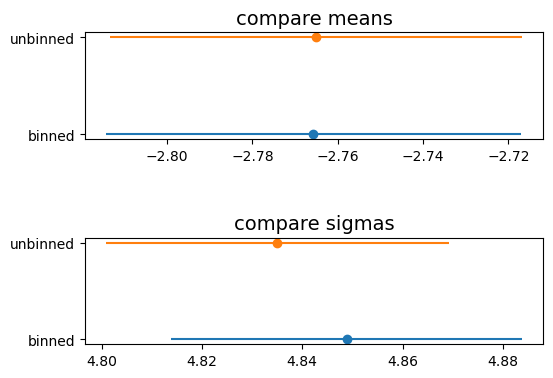

In [4]:
fig, axes = plt.subplots (2, 1)

# setting the two sub-figures apart
fig.tight_layout (pad=5.0)

# plot means
axes[0].set_title ('compare means', size=14)
axes[0].errorbar (mean_bin[0], 'binned', xerr = mean_bin[1], marker = 'o')
axes[0].errorbar (mean_unb[0], 'unbinned', xerr = mean_unb[1], marker = 'o')

#plot sigmas
axes[1].set_title ('compare sigmas', size=14)
axes[1].errorbar (sigma_bin[0], 'binned', xerr = sigma_bin[1], marker = 'o')
axes[1].errorbar (sigma_unb[0], 'unbinned', xerr = sigma_unb[1], marker = 'o')

plt.show ()


# Binned fits solutions: exercise 12.3

Insert the source code of the previous exercise into a loop
that performs the comparison as the number of events considered for the fit varies,
from ```20``` to ```10000```, with a regular log-scale increment.
  * Use different plots
    to show the behavior of the parameters and their uncertainties
    as the number of events changes, for both types of estimators.
  * Add to the comparison the fit performed with the least squares method.
  * Which estimator is less biased at low statistics?


### binned likelihood
To determine the bias, the estimator expectation value is needed, hence for each sample size to be fitted several toy experiments need to be performed, and their average to be calculated

In [5]:
from matplotlib import pyplot as plt
import numpy as np
from myrand import generate_TCL_ms
from iminuit import Minuit
from scipy.stats import norm
from iminuit.cost import ExtendedBinnedNLL
from math import floor, ceil, sqrt

# for the binning choice
def sturge (N) :
    return floor (1 + 3.322 * np.log (N))

sample_size = 20
N_toys = 50
N_evt = 10000
means_bin = []
sigmas_bin = []
events = []
while sample_size < N_evt :
    means_size = []
    sigmas_size = []
    for iToy in range (N_toys) :
        subsample = generate_TCL_ms (1., 0.7, sample_size)
        bin_content, bin_edges = np.histogram (subsample, bins = sturge (sample_size), 
                                               range = (floor (min (subsample)), ceil (max (subsample))))

        def mod_signal_bin (bin_edges, N_signal, mu, sigma):
            return N_signal * norm.cdf (bin_edges, mu, sigma)
        
        my_cost_func_bin = ExtendedBinnedNLL (bin_content, bin_edges, mod_signal_bin)
        my_minuit_bin = Minuit (
                                my_cost_func_bin, 
                                N_signal = sum (bin_content), 
                                mu = np.mean (subsample), 
                                sigma = np.std (subsample),
                               )
        my_minuit_bin.limits['N_signal', 'sigma'] = (0, None)
        my_minuit_bin.migrad ()
        if not my_minuit_bin.valid : continue
        means_size.append (my_minuit_bin.values[1])
        sigmas_size.append (my_minuit_bin.values[2])
    events.append (sample_size)
    means_bin.append ([np.mean (means_size), np.std (means_size)])
    sigmas_bin.append ([np.mean (sigmas_size), np.std (sigmas_size)])
    sample_size = sample_size * 2    

### unbinned likelihood

In [6]:
from iminuit.cost import UnbinnedNLL

def mod_signal_unb (x, mu, sigma) :
    return norm.pdf(x, mu, sigma)

sample_size = 20
means_unb = []
sigmas_unb = []
while sample_size < N_evt :
    means_size = []
    sigmas_size = []
    for iToy in range (N_toys) :
        subsample = generate_TCL_ms (1., 0.7, sample_size)
        my_cost_func_unb = UnbinnedNLL (subsample, mod_signal_unb)
        my_minuit_unb = Minuit (
                                my_cost_func_unb, 
                                mu = np.mean (subsample), 
                                sigma = np.std (subsample),
                               )
        my_minuit_unb.limits["sigma"] = (0, None)
        my_minuit_unb.migrad ()
        if not my_minuit_unb.valid : continue
        means_size.append (my_minuit_unb.values[0])
        sigmas_size.append (my_minuit_unb.values[1])
    
    means_unb.append ([np.mean (means_size), np.std (means_size)])
    sigmas_unb.append ([np.mean (sigmas_size), np.std (sigmas_size)])
    sample_size = sample_size * 2    

### least squares

In [7]:
from iminuit.cost import LeastSquares

def sturges (N_events) :
    return ceil (1 + np.log2 (N_events))

def func_approx (x, N_events, mean, sigma, bin_width) :
    return N_events * norm.pdf (x, mean, sigma) * bin_width

sample_size = 20
means_ls = []
sigmas_ls = []
while sample_size < N_evt :
    means_size = []
    sigmas_size = []
    for iToy in range (N_toys) :
        subsample = generate_TCL_ms (1., 0.7, sample_size)
        bin_content, bin_edges = np.histogram (subsample, bins = sturges (sample_size), 
                                               range = (floor (min (subsample)), ceil (max (subsample))))
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        sigma_y = [max (sqrt (num), 1.) for num in bin_content]

        least_squares = LeastSquares (bin_centres, bin_content, sigma_y, func_approx)
        my_minuit_ls = Minuit (least_squares,
                               N_events = sample_size,
                               mean = np.mean (subsample), 
                               sigma = np.std (subsample),
                               bin_width = bin_centres[1] - bin_centres[0]
                              )
        my_minuit_ls.fixed["bin_width", "N_events"] = True
        my_minuit_ls.migrad ()
        my_minuit_ls.hesse ()
        if not my_minuit_ls.valid : continue
        means_size.append (my_minuit_ls.values[1])
        sigmas_size.append (my_minuit_ls.values[2])

    means_ls.append ([np.mean (means_size), np.std (means_size)])
    sigmas_ls.append ([np.mean (sigmas_size), np.std (sigmas_size)])
    sample_size = sample_size * 2            

### compare the three estimates

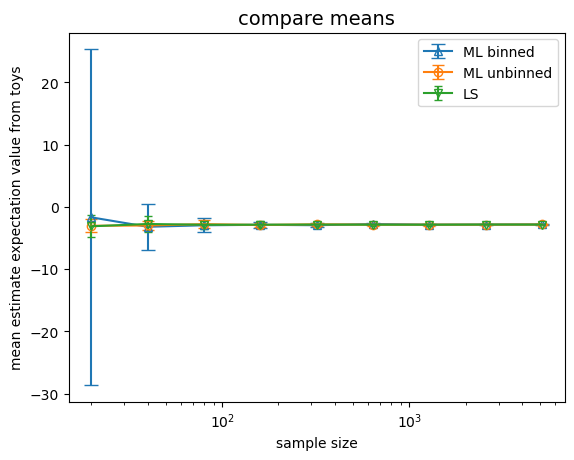

In [8]:
fig, ax = plt.subplots (1, 1)
ax.set_title ('compare means', size=14)
ax.set_xlabel ('sample size')
ax.set_ylabel ('mean estimate expectation value from toys')

means_bin_val, means_bin_err = map (list, zip (*means_bin))
ax.errorbar (events, means_bin_val, yerr = means_bin_err, marker = '^', markerfacecolor = 'none', label = 'ML binned', capsize = 5)

means_unb_val, means_unb_err = map (list, zip (*means_unb))
ax.errorbar (events, means_unb_val, yerr = means_unb_err, marker = 'o', markerfacecolor = 'none', label = 'ML unbinned', capsize = 4)

means_ls_val, means_ls_err = map (list, zip (*means_ls))
ax.errorbar (events, means_ls_val, yerr = means_ls_err, marker = 'v', markerfacecolor = 'none', label = 'LS', capsize = 3)

plt.xscale ("log")

ax.legend ()
plt.show ()



# cost functions comparison: exercise 12.4

## Exercise 12.4

Starting from samples of pseudo-random numbers generated 
according to a Gaussian probability density function,
using the technique of the toy experiments
study the distribution of the minimum of the cost function
used by `iminuit` in Gaussian fits.
  * Does it match a $\chi^2$ distribution for any number of events,
    for the cases of maximum likelihood, extended maximum likelihood, and least squares?

In [10]:
from matplotlib import pyplot as plt
import numpy as np
from myrand import generate_TCL_ms
from iminuit import Minuit
from scipy.stats import norm
from math import floor, ceil, sqrt

# for the binning choice
def sturges (N) :
    return floor (1 + np.log2 (N))

# parameters valid for all tests
N_toys = 5000
sample_size = 500    
bins = sturges (sample_size)

### binned likelihood

In [11]:
from iminuit.cost import BinnedNLL

def mod_signal_bin_LL (bin_edges, mu, sigma) :
    ''' fitting model for binned likelihood'''
    return norm.cdf (bin_edges, mu, sigma)
        
means_bin_LL = []
sigmas_bin_LL = []
Q2_bin_LL = []
N_dof_LL = 0

for iToy in range (N_toys) :
    subsample = generate_TCL_ms (1., 0.7, sample_size)
    bin_content, bin_edges = np.histogram (subsample, bins, 
                                           range = (floor (min (subsample)), ceil (max (subsample))))

    my_cost_func_bin_LL = BinnedNLL (bin_content, bin_edges, mod_signal_bin_LL)
    my_minuit_bin_LL = Minuit (
                            my_cost_func_bin_LL, 
                            mu = np.mean (subsample), 
                            sigma = np.std (subsample),
                           )
    my_minuit_bin_LL.limits['sigma'] = (0, None)
    my_minuit_bin_LL.migrad ()
    if not my_minuit_bin_LL.valid : continue
    means_bin_LL.append (my_minuit_bin_LL.values['mu'])
    sigmas_bin_LL.append (my_minuit_bin_LL.values['sigma'])
    Q2_bin_LL.append (my_minuit_bin_LL.fval)
    if (iToy == 0) : N_dof_LL = my_minuit_bin_LL.ndof

### extended binned likelihood

In [12]:
from iminuit.cost import ExtendedBinnedNLL

def mod_signal_bin_ext_LL (bin_edges, N_signal, mu, sigma) :
    ''' fitting model for extended binned likelihood'''
    return N_signal * norm.cdf (bin_edges, mu, sigma)
        
means_bin_ext_LL = []
sigmas_bin_ext_LL = []
Q2_bin_ext_LL = []
N_dof_ext_LL = 0

for iToy in range (N_toys) :
    subsample = generate_TCL_ms (1., 0.7, sample_size)
    bin_content, bin_edges = np.histogram (subsample, bins, 
                                           range = (floor (min (subsample)), ceil (max (subsample))))

    my_cost_func_bin_ext_LL = ExtendedBinnedNLL (bin_content, bin_edges, mod_signal_bin_ext_LL)
    my_minuit_bin_ext_LL = Minuit (
                            my_cost_func_bin_ext_LL, 
                            N_signal = len (subsample),
                            mu = np.mean (subsample), 
                            sigma = np.std (subsample),
                           )
    my_minuit_bin_ext_LL.limits['N_signal', 'sigma'] = (0, None)
    my_minuit_bin_ext_LL.migrad ()
    if not my_minuit_bin_ext_LL.valid : continue
    means_bin_ext_LL.append (my_minuit_bin_ext_LL.values['mu'])
    sigmas_bin_ext_LL.append (my_minuit_bin_ext_LL.values['sigma'])
    Q2_bin_ext_LL.append (my_minuit_bin_ext_LL.fval)
    if (iToy == 0) : N_dof_ext_LL = my_minuit_bin_ext_LL.ndof


### least squares

In [13]:
from iminuit.cost import LeastSquares

def func_approx (x, N_events, mean, sigma, bin_width) :
    return N_events * norm.pdf (x, mean, sigma) * bin_width

means_LS = []
sigmas_LS = []
Q2_bin_LS = []
N_dof_LS = 0

for iToy in range (N_toys) :
    subsample = generate_TCL_ms (1., 0.7, sample_size)
    bin_content, bin_edges = np.histogram (subsample, bins, 
                                           range = (floor (min (subsample)), ceil (max (subsample))))
    bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    sigma_y = [max (sqrt (num), 1.) for num in bin_content]

    least_squares = LeastSquares (bin_centres, bin_content, sigma_y, func_approx)
    my_minuit_LS = Minuit (least_squares,
                           N_events = sample_size,
                           mean = np.mean (subsample), 
                           sigma = np.std (subsample),
                           bin_width = bin_centres[1] - bin_centres[0]
                          )
    my_minuit_LS.fixed["bin_width", "N_events"] = True
    my_minuit_LS.migrad ()
    my_minuit_LS.hesse ()
    if not my_minuit_LS.valid : continue
    means_LS.append (my_minuit_LS.values['mean'])
    sigmas_LS.append (my_minuit_LS.values['sigma'])
    Q2_bin_LS.append (my_minuit_LS.fval)
    if (iToy == 0) : N_dof_LS = my_minuit_LS.ndof


### compare the five estimates

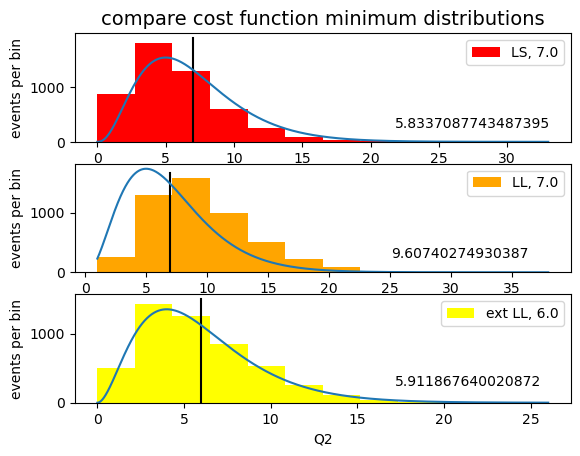

In [15]:
from scipy.stats import chi2

def plot_histo (ax, sample, ndof, label, color) :
    xMin = floor (min (sample))
    xMax = ceil (max (sample))
    N_bins = sturges (len (sample))
    bin_edges = np.linspace (xMin, xMax, N_bins)
    ax.set_xlabel ('Q2')
    ax.set_ylabel ('events per bin')
    ax.hist (sample,
             bins = bin_edges,
             color = color,
             label = label + ', ' + str (ndof),
            )
    vertical_limits = ax.get_ylim ()
    ax.plot ([ndof, ndof], vertical_limits, color = 'black')
    ax.legend ()

    x = np.arange (xMin, xMax, 0.001)
    bin_width = (xMax - xMin) / N_bins
    ax.plot (x, bin_width * len (sample) * chi2.pdf (x, df=ndof))
    ax.text (0.66 * xMax, len (sample) / 20., str (sum (sample) / len (sample)))
    
    
    
fig, axes = plt.subplots (nrows = 3, ncols = 1)
axes[0].set_title ('compare cost function minimum distributions', size=14)

plot_histo (axes[0], Q2_bin_LS, N_dof_LS, 'LS', 'red')
plot_histo (axes[1], Q2_bin_LL, N_dof_LL, 'LL', 'orange')
plot_histo (axes[2], Q2_bin_ext_LL, N_dof_ext_LL, 'ext LL', 'yellow')


